In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
# Vijay Patidar (22MCA1030)
# Rohit Vishwakarma (22MCA1104)
# Charchika Priya (22MCA1124)
# Tahir Madrash (22MCA1122)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.12.0


In [ ]:
od.download("https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition?resource=download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading fruit-and-vegetable-image-recognition.zip to ./fruit-and-vegetable-image-recognition


100%|██████████| 1.98G/1.98G [00:28<00:00, 75.6MB/s]


In [ ]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir = Path('/content/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
val_dir = Path('/content/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['cabbage' 'eggplant' 'apple' 'bell pepper' 'paprika' 'lemon' 'tomato'
 'chilli pepper' 'capsicum' 'banana' 'watermelon' 'pineapple' 'raddish'
 'onion' 'lettuce' 'jalepeno' 'sweetcorn' 'kiwi' 'beetroot' 'carrot'
 'garlic' 'orange' 'pear' 'ginger' 'sweetpotato' 'soy beans' 'mango'
 'potato' 'grapes' 'corn' 'peas' 'turnip' 'spinach' 'pomegranate'
 'cucumber' 'cauliflower']


In [ ]:
train_df.head(5)

,Filepath,Label
0,/content/fruit-and-vegetable-image-recognition...,cabbage
1,/content/fruit-and-vegetable-image-recognition...,eggplant
2,/content/fruit-and-vegetable-image-recognition...,apple
3,/content/fruit-and-vegetable-image-recognition...,bell pepper
4,/content/fruit-and-vegetable-image-recognition...,paprika


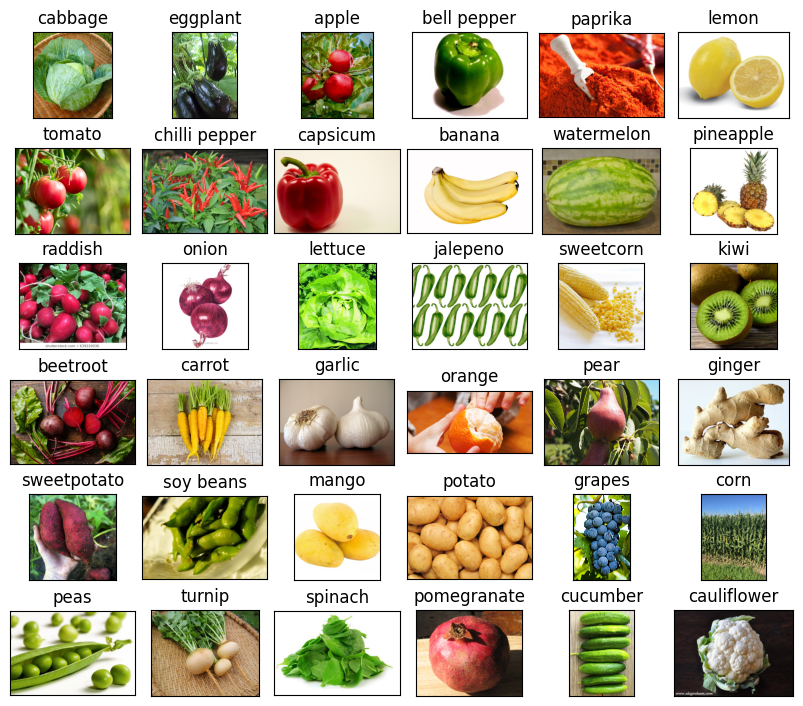

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 202s 2s/step - loss: 1.6986 - accuracy: 0.5532 - val_loss: 0.4594 - val_accuracy: 0.8593
Epoch 2/5
87/87 [==============================] - 237s 3s/step - loss: 0.5352 - accuracy: 0.8335 - val_loss: 0.3030 - val_accuracy: 0.9072
Epoch 3/5
87/87 [==============================] - 210s 2s/step - loss: 0.3317 - accuracy: 0.8899 - val_loss: 0.2037 - val_accuracy: 0.9311
Epoch 4/5
87/87 [==============================] - 206s 2s/step - loss: 0.2203 - accuracy: 0.9371 - val_loss: 0.1976 - val_accuracy: 0.9461
Epoch 5/5
87/87 [==============================] - 203s 2s/step - loss: 0.1478 - accuracy: 0.9554 - val_loss: 0.2080 - val_accuracy: 0.9491


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 44s 4s/step


['watermelon',
 'pineapple',
 'tomato',
 'kiwi',
 'apple',
 'cabbage',
 'tomato',
 'pineapple',
 'tomato',
 'pomegranate',
 'onion',
 'kiwi',
 'bell pepper',
 'garlic',
 'peas',
 'capsicum',
 'peas',
 'soy beans',
 'sweetpotato',
 'soy beans',
 'banana',
 'eggplant',
 'jalepeno',
 'mango',
 'tomato',
 'onion',
 'peas',
 'cucumber',
 'grapes',
 'paprika',
 'kiwi',
 'apple',
 'tomato',
 'orange',
 'bell pepper',
 'tomato',
 'cauliflower',
 'paprika',
 'garlic',
 'lemon',
 'apple',
 'raddish',
 'spinach',
 'soy beans',
 'peas',
 'lettuce',
 'eggplant',
 'potato',
 'pear',
 'eggplant',
 'pear',
 'apple',
 'spinach',
 'cucumber',
 'spinach',
 'turnip',
 'lettuce',
 'onion',
 'corn',
 'sweetcorn',
 'sweetpotato',
 'peas',
 'turnip',
 'eggplant',
 'potato',
 'cauliflower',
 'beetroot',
 'tomato',
 'cucumber',
 'lemon',
 'ginger',
 'grapes',
 'kiwi',
 'garlic',
 'pineapple',
 'onion',
 'spinach',
 'eggplant',
 'eggplant',
 'jalepeno',
 'soy beans',
 'pineapple',
 'sweetpotato',
 'paprika',
 'b

In [ ]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
img = output('/content/fruit-and-vegetable-image-recognition/test/garlic/Image_1.jpg')
img





1/1 [==============================] - 1s 1s/step


'garlic'

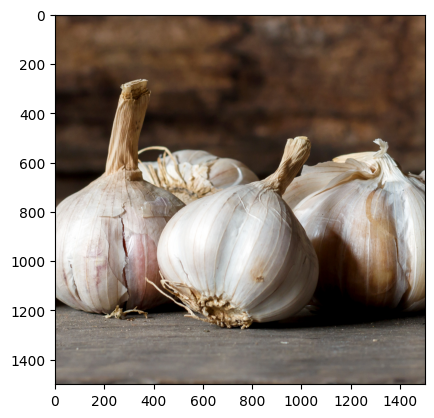

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/fruit-and-vegetable-image-recognition/test/garlic/Image_1.jpg')
plt.imshow(img)
plt.show()

In [ ]:
model.save('FV.h5')

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
import requests
from bs4 import BeautifulSoup
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


model = load_model('FV.h5')

labels = {0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot',
          7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger',
          14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce',
          19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple',
          26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn',
          32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}

fruits = ['Apple', 'Banana', 'Bello Pepper', 'Chilli Pepper', 'Grapes', 'Jalepeno', 'Kiwi', 'Lemon', 'Mango', 'Orange',
          'Paprika', 'Pear', 'Pineapple', 'Pomegranate', 'Watermelon']
vegetables = ['Beetroot', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Corn', 'Cucumber', 'Eggplant', 'Ginger',
              'Lettuce', 'Onion', 'Peas', 'Potato', 'Raddish', 'Soy Beans', 'Spinach', 'Sweetcorn', 'Sweetpotato',
              'Tomato', 'Turnip']


def fetch_calories(prediction):
    try:
        url = 'https://www.google.com/search?&q=calories in ' + prediction
        req = requests.get(url).text
        scrap = BeautifulSoup(req, 'html.parser')
        calories = scrap.find("div", class_="BNeawe iBp4i AP7Wnd").text
        return calories
    except Exception as e:
        st.error("Can't able to fetch the Calories")
        print(e)


def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, [0])
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    print(res)
    return res.capitalize()


def run():
    st.title("Fruits🍍-Vegetable🍅 Classification")
    img_file = st.file_uploader("Choose an Image", type=["jpg", "png"])
    if img_file is not None:
        img = Image.open(img_file).resize((250, 250))
        st.image(img, use_column_width=False)
        save_image_path = './upload_images/' + img_file.name
        with open(save_image_path, "wb") as f:
            f.write(img_file.getbuffer())

        # if st.button("Predict"):
        if img_file is not None:
            result = prepare_image(save_image_path)
            if result in vegetables:
                st.info('**Category : Vegetables**')
            else:
                st.info('**Category : Fruit**')
            st.success("**Predicted : " + result + '**')
            cal = fetch_calories(result)
            if cal:
                st.warning('**' + cal + '(100 grams)**')


run()

Overwriting app.py


In [ ]:
!streamlit run app.py  & npx localtunnel  --port 8501


[..................] | fetchMetadata: sill resolveWithNewModule debug@4.3.2 che


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.83.238.170:8501

npx: installed 22 in 9.021s
your url is: https://eleven-bobcats-drum.loca.lt
2023-08-09 08:42:28.255579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-09 08:43:33.515 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 552, in _run_script
    exec(code, module.__dict__)
  File "/content/app.py", line 76, in <module>
    run()
  File "/content/app.py", line 60, in run
    with open(save_image_path, "wb") as f:
FileNotFoundError: [Errno 2] No such file or directory: './upload_images/download.jpeg'
